Tp3 incisos a y b

In [2]:
#### Modulos
import networkx as nx
import matplotlib.pylab as plt
%matplotlib inline
import os
import numpy as np
import rpy2.robjects as robjects
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
import matplotlib.pyplot as plt; plt.rcdefaults()
from networkx.algorithms.community.centrality import girvan_newman
from operator import itemgetter
from scipy import stats
#################

In [3]:
G = nx.read_gml("dolphins.gml")


In [4]:
#### Este es el algoritmo que utiliza packetes de redes en R para defirnir comunidades
def community(nxG, algorithm, fig_name = "G"):
    """
    In:
        nxG: grafo de networkx.
        algorithm: string, entre las siguientes opciones: 
            fast_greedy
            edge_betweenness
            louvain
            infomap
        fig_name: nombre de la figura que se genera al clsuterizar. Le agrega automaticamente el nombre del algoritmo usado y el nombre del grafo si lo tuviere
    Out:
        labels: numpy array con la pertenencia de cada nodo al cluster.
    
    """
    gml_file_name = "G.gml"
    fig_name += "_"+nxG.name+"_"+algorithm+".svg"
    nx.write_gml(nxG, gml_file_name)
    
    igG = robjects.r('''
        f <- function(file, algorithm, fig_name, v_names){
            require("igraph")     
            
            G <- read.graph(file, "gml")
            V(G)$name <- as.character(unlist(v_names))
            #format = c("edgelist", "pajek", "ncol", "lgl", "graphml","dimacs", "graphdb", "gml", "dl"), ...)
            
            if(algorithm == "fast_greedy"){
                c <- fastgreedy.community(G)
                #c <- cluster_fast_greedy(G, merges = TRUE, modularity = TRUE, membership = TRUE)
            }
            
            if(algorithm == "edge_betweenness"){
                c <- edge.betweenness.community(G)
                #c <- cluster_edge_betweenness(G,directed = FALSE,edge.betweenness = TRUE)
            }
            
            if(algorithm == "louvain"){
                c <- multilevel.community(G)
                #c <- cluster_louvain(G)
            }
            
            if(algorithm == "infomap"){
                #c <- cluster_infomap(G)
                c <- infomap.community(G)
            }
            
            svg(fig_name)
            plot(c, G)
            dev.off()
            
            return(list(membership(c), as.character(V(G)$name)))
        }
    ''')
    
    labels = igG(gml_file_name, algorithm, fig_name, list(dict(nxG.nodes(data=True)).keys()))
    os.remove(gml_file_name)
    return {name: int(label) for name, label in zip(labels[1],labels[0])}

In [5]:
def Silmod(G, labels, fig_name = "G",metodo= "metodo"):  ####Esta es una funcion, a la que uno le da un grafo G
                    #####una particion (labels) y Silmod devuelve la modularidad, el silhouette promedio
                ##### La red con las particionnes en colores y el grafico del silhouette con todos los valores
            ##### incluyendo el silhouette promedio con una linea punteada negra
        ####Observacion, "metodo" es el nombre del metodo que se uso y sirve para los outputsfile y guardadoo de imagenes
    comus=[]
    f=[]
    maxlabel=max(labels.values())
    i=0
    for i in range(maxlabel):
        f.append([])
        for key in labels:
            if int(labels[key]) == i+1:
                f[i].append(key)
        comus.append(frozenset(f[i]))
    comus

    ###### Generar lista de edges de "dolphins.gml"
    edges = nx.write_edgelist(G,"Dolphins_edge_list.txt")
    filEdges = open("Dolphins_edge_list.txt", "r").readlines()	
    edgeList = []
    for a in range(len(filEdges)):
        edgeLine = filEdges[a].split()
        tupla = (edgeLine[0],edgeLine[1])
        edgeList.append(tupla)
    ###### OutputFile
    outputFile= open("./Silhouette_y_modularidad_%s.txt"%(metodo), "w")
    ##### Silhouette #################################
    ##################################################
    ###### Definir all_nodes y community_lists
    all_nodes = []
    comuList = []
    outputFile.write("Comunidades %s"%(metodo) + "\n")
    for x in range(len(comus)):
        lista = list(comus[x])
        all_nodes = all_nodes + lista
        comuList.append(tuple(lista))	
        str1 = ','.join(lista) 
        outputFile.write("Community_%s:"%str(x) + str1 + "\n")
        # Defino node_community_lists
        globals()['node_list_community%s' % x] = lista

    print(comuList)
    count=0
    Dict={}
    listSilhs = []
    for i in range(maxlabel):
        listSilhs.append([])
    ### Separar comuList en listas de comunidades
    for q in range(len(comuList)):
        comm = (list(comuList[q]))	

        # Abro y defino comunidad No X
        globals()['community_%s' % q] = comm

        # Abro la comunidad No X y determino la shortest_path_length de cada uno de sus nodos con respecto a todo el grafo
        for m in range(len(comm)):

            # Defino Nodo como "source"
            source = comm[m]

            # Diccionario de shorttest path length desde el nodo "source" hasta el resto de los nodos del grafo
            spl = nx.multi_source_dijkstra_path_length(G, [source])

            # Variables ##########################################
            # Defino las variables suma y total para calcular a(i)
            suma = 0
            #total = len(globals()['community_%s' % q])
            total = len(comuList[q])

            # Defino las variables suma_x y total_x para calcular b(i) del resto de las comunidades
            for w  in range(len(comuList)):	
                globals()['suma_%s' % w] = 0
                globals()['total_%s' % w] = len(comuList[w])
            ######################################################	

            # Abro el diccionario spl, y calculo a(i), b(i)
            for x,y in spl.items():

                # Si el nodo esta en la comunidad: sumar la dist para calcular a(i) promediando
                if x in (globals()['community_%s' % q]):	
                    suma = suma + y

                # Si el nodo NO esta en la comunidad q del inicio del loop: 
                if x not in (globals()['community_%s' % q]):	

                    # Volver a abrir la lista de comunidades
                    for w  in range(len(comuList)):	

                        # Y sumar la dist correspondiente a cada comunidad para b(i)
                        if x in globals()['node_list_community%s' % w]:
                            globals()['suma_%s' % w] = globals()['suma_%s' % w] + y


            # Determinacion de a(i)
            ai = suma/total

            # Determinacion de b(i)
            bi_list = []
            for oo in range(len(comuList)):
                globals()['promedio_%s' % oo] = (globals()['suma_%s' % oo])/(globals()['total_%s' % oo])
                if globals()['promedio_%s' % oo] != 0.0:
                    bi_list.append(globals()['promedio_%s' % oo])

            bi = min(bi_list)
            MAX =  max(ai, bi)
            Silh = (bi - ai)/MAX

            # Guardar Silh en una lista para cada comunidad:
            listSilhs[q].append(tuple([source,Silh]))
        listSilhs[q].sort(key=itemgetter(1))

    ##################################################
    ##################################################
    
            #### Calculo del silhouette promedio
    pp=0
    llistasilh=[]
    for ii in range(len(listSilhs)):
        for jj in range(len(listSilhs[ii])):
            llistasilh.append(((listSilhs[ii])[jj])[1])


    for si in range(len(llistasilh)): ####no se si esta parte esta bien, para mi que hay que quitarle un tab pero da un solo silhuette para cualquier caso
        pp=pp+llistasilh[si]
    s = pp/(len(llistasilh))
    #print("El silhouette promedio es : %s"%str(s))
    outputFile.write("El silhouette promedio es :%s"%str(s) + '\n')
    
    ##################################################################
    ##### Plotear Silhouette #########################################
    objects = []
    performance = []

    # Armar lista de colorIdenx
    colorIndex = []
    for li in range(len(listSilhs)):
        for co in range(len(listSilhs[li])):
            tup=(listSilhs[li])[co]
            objects.append(tup[0])
            performance.append(tup[1])
        colorIndex.append(	len(listSilhs[li]))
    colorIndex.reverse()

    # Definir lista de nombres de colores
    colorName=[]
    for i in range(len(colorIndex)):
        if i==0:
            colorName.append('y')
        elif i==1:
            colorName.append('slateblue')
        elif i==2:
            colorName.append('indianred')  
        elif i==3:
            colorName.append('cadetblue')
        elif i==4:
            colorName.append('slategrey')
        elif i==5:
            colorName.append('seagreen')
        elif i==6:
            colorName.append('darkkhaki')
        elif i==7:
            colorName.append('olive')
        elif i==8:
            colorName.append('saddlebrown')
        elif i==9:
            colorName.append('blue')
        elif i==10:
            colorName.append('goldenrod')
        elif i==11:
            colorName.append('olivedrab')
        elif i==12:
            colorName.append('streetblue')
        elif i==13:
            colorName.append('y')
        elif i==14:
            colorName.append('red')
        elif i==15:
            colorName.append('firebrick')


    #colorName = ['green', 'blue', 'red', 'cyan', 'yellow','darkgray','bisque', 'black', 'pink','brown', 'cadetblue']

    # Armar lista de colores con la cantidad correspondiente a cada comunidad
    COLOR = []
    for col in range(len(colorIndex)):
        for colo in range(colorIndex[col]):
            COLOR.append(colorName[col])
    COLOR.reverse()
        # Ploteo
    SSx=[]
    SSy=[]
    for qp in range(len(performance)):
        SSx.append(s)
        SSy.append(qp)


    
    y_pos = np.arange(len(objects))	
    plt.barh(y_pos, performance, align='center', alpha=0.8,color=COLOR )
    plt.plot(SSx,SSy,'k--',linewidth = 0.8)
    plt.yticks(y_pos, objects, fontsize=6)
    plt.xlabel('S(i)')
    plt.title('Silhouette clustering')
    plt.savefig('%s_silhouette.png' %(metodo))
    plt.show()
    ##################################################################
    ##################################################################

    ###### Calculo de modularidad
    q = nx.algorithms.community.modularity(G,comus)
    print("La modularidad es : %s"%str(q))
    print("El silhouette promedio es : %s"%str(s))
    outputFile.write("La modularidad es : %s"%str(q) + '\n')

    ###################################################################
    ###### Plotear grafo con comunidades ##############################
    G3 = nx.Graph()
    for n in all_nodes:
        G3.add_node(n)
    for from_loc, to_loc in edgeList:
        G3.add_edge(from_loc, to_loc)

    pos = nx.kamada_kawai_layout(G3) 
    nx.draw(G3, pos, edge_color='k',  with_labels=True,font_weight='light', node_size= 80, width= 0.9)

    # Graficar la red con un color para cada comunidad, igual al empleado en Silhouette
    colorName.reverse()
    for col in range(len(colorIndex)):
        nx.draw_networkx_nodes(G3, pos, nodelist=globals()['node_list_community%d'% col], node_color=colorName[col], node_size=120)
    plt.savefig('labels_%s.png' %(metodo))
    plt.show()   
    
    
    outputFile.close()

In [6]:
def Rmod(G, labels, fig_name = "G"):  ##### Esta funcion esta pensada paara ser utilizada iterativamente con varias 
                                #### randomizaciones de la red, entonces uno le da el grafo, la particion y Rmod
                                ### devuelve la modularidad
    comus=[]
    f=[]
    maxlabel=max(labels.values())
    i=0
    for i in range(maxlabel):
        f.append([])
        for key in labels:
            if int(labels[key]) == i+1:
                f[i].append(key)
        comus.append(frozenset(f[i]))
    q = nx.algorithms.community.modularity(G,comus)
    #print("La modularidad (q) es : " + str(q))        
    return q

In [7]:
def Rsil(G, labels, fig_name = "G"):  ##### Esta funcion esta pensada para ser utilizada iterativamente con varias 
                                #### randomizaciones de la red, entonces uno le da el grafo, la particion y Rsil
                                ### devuelve el silhouette promedio
    comus=[]
    f=[]
    maxlabel=max(labels.values())
    i=0
    for i in range(maxlabel):
        f.append([])
        for key in labels:
            if int(labels[key]) == i+1:
                f[i].append(key)
        comus.append(frozenset(f[i]))
    comus
    ###### OutputFile
    #outputFile= open("./scripttp03_infomap_communities.txt", "w")
    ###### Generar lista de edges de "dolphins.gml"
    edges = nx.write_edgelist(G,"Dolphins_edge_list.txt")
    filEdges = open("Dolphins_edge_list.txt", "r").readlines()	
    edgeList = []
    for a in range(len(filEdges)):
        edgeLine = filEdges[a].split()
        tupla = (edgeLine[0],edgeLine[1])
        edgeList.append(tupla)

    ##### Silhouette #################################
    ##################################################
    ###### Definir all_nodes y community_lists
    all_nodes = []
    comuList = []
    for x in range(len(comus)):
        lista = list(comus[x])
        all_nodes = all_nodes + lista
        comuList.append(tuple(lista))	
        str1 = ','.join(lista) 
        #outputFile.write("Community: " + str1 + "\n")
        # Defino node_community_lists
        globals()['node_list_community%s' % x] = lista

  
    count=0
    Dict={}
    listSilhs = []
    for i in range(maxlabel):
        listSilhs.append([])
    ### Separar comuList en listas de comunidades
    for q in range(len(comuList)):
        comm = (list(comuList[q]))	

        # Abro y defino comunidad No X
        globals()['community_%s' % q] = comm

        # Abro la comunidad No X y determino la shortest_path_length de cada uno de sus nodos con respecto a todo el grafo
        for m in range(len(comm)):

            # Defino Nodo como "source"
            source = comm[m]

            # Diccionario de shorttest path length desde el nodo "source" hasta el resto de los nodos del grafo
            spl = nx.multi_source_dijkstra_path_length(G, [source])

            # Variables ##########################################
            # Defino las variables suma y total para calcular a(i)
            suma = 0
            #total = len(globals()['community_%s' % q])
            total = len(comuList[q])

            # Defino las variables suma_x y total_x para calcular b(i) del resto de las comunidades
            for w  in range(len(comuList)):	
                globals()['suma_%s' % w] = 0
                globals()['total_%s' % w] = len(comuList[w])
            ######################################################	

            # Abro el diccionario spl, y calculo a(i), b(i)
            for x,y in spl.items():

                # Si el nodo esta en la comunidad: sumar la dist para calcular a(i) promediando
                if x in (globals()['community_%s' % q]):	
                    suma = suma + y

                # Si el nodo NO esta en la comunidad q del inicio del loop: 
                if x not in (globals()['community_%s' % q]):	

                    # Volver a abrir la lista de comunidades
                    for w  in range(len(comuList)):	

                        # Y sumar la dist correspondiente a cada comunidad para b(i)
                        if x in globals()['node_list_community%s' % w]:
                            globals()['suma_%s' % w] = globals()['suma_%s' % w] + y


            # Determinacion de a(i)
            ai = suma/total

            # Determinacion de b(i)
            bi_list = []
            for oo in range(len(comuList)):
                globals()['promedio_%s' % oo] = (globals()['suma_%s' % oo])/(globals()['total_%s' % oo])
                if globals()['promedio_%s' % oo] != 0.0:
                    bi_list.append(globals()['promedio_%s' % oo])

            bi = min(bi_list)
            MAX =  max(ai, bi)
            Silh = (bi - ai)/MAX
                        
            # Guardar Silh en una lista para cada comunidad:
            listSilhs[q].append(tuple([source,Silh]))
        listSilhs[q].sort(key=itemgetter(1))

        
        #### Calculo del silhouette promedio
    pp=0
    llistasilh=[]
    for ii in range(len(listSilhs)):
        for jj in range(len(listSilhs[ii])):
            llistasilh.append(((listSilhs[ii])[jj])[1])


    for si in range(len(llistasilh)): ####no se si esta parte esta bien, para mi que hay que quitarle un tab pero da un solo silhuette para cualquier caso
        pp=pp+llistasilh[si]
    s = pp/(len(llistasilh))
    #print("El silhouette promedio es : " + str(silhpromedio))
    return s

In [8]:
def pvalue(PQ,mmm, PS,sss):
    qpv=0
    pqx=list(PQ[0])
    pqy=list(PQ[1])
    for i in range(len(pqx)):
        if pqx[i]>=max(pqx):
            mqy=pqy[i]
    for lql in range(len(pqx)):
        if mqy < mmm:
            if pqy[lql]>mmm:
                qpv=pqv+int(pqx[lql])
        if mqy> mmm:
            if pqy[lql]<mmm:
                qpv=qpv+int(pqx[lql])
    qpvalue=qpv/float(len(pqx))

    print("el pvalor de la modularidad es %s"%qpvalue)
    

    
    
    spv=0
    psx=list(PS[0])
    psy=list(PS[1])
    for i in range(len(psx)):
        if psx[i]>=max(psx):
            msy=psy[i]
    for lsl in range(len(psx)):
        if msy < sss:
            if psy[lsl]>sss:
                spv=spv+int(psx[lsl])
        if msy> sss:
            if psy[lsl]<sss:
                spv=spv+int(psx[lsl])
                
    spvalue=spv/float(len(psx))


    

    print("el pvalor del slihouette es %s"%spvalue)
    
    

[('Kringel', 'SN63', 'SN4', 'TR99', 'Hook', 'Stripes', 'Grin', 'TSN103', 'Zipfel', 'TR120', 'Scabs', 'Shmuddel', 'Fork', 'SN9', 'TR88', 'TSN83', 'Thumper', 'Whitetip'), ('DN16', 'Quasi', 'MN23', 'Zig', 'Gallatin', 'Ripplefluke', 'SN90', 'Feather', 'Jet', 'TR82', 'Upbang', 'Web', 'Wave', 'DN21'), ('Haecksel', 'Patchback', 'Jonah', 'Topless', 'MN105', 'SMN5', 'Five', 'MN60', 'Cross', 'Vau', 'Trigger', 'MN83'), ('Notch', 'Knit', 'Oscar', 'PL', 'DN63', 'Mus', 'Number1', 'Beescratch'), ('Beak', 'SN96', 'Bumper', 'Fish', 'TR77'), ('Double', 'SN89', 'CCL', 'SN100', 'Zap')]


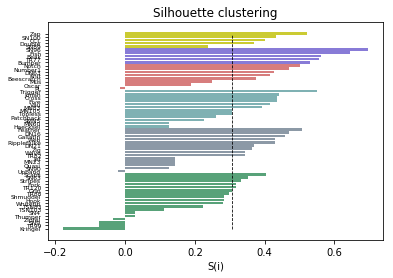

La modularidad es : 0.5189470353229684
El silhouette promedio es : 0.306852051677683


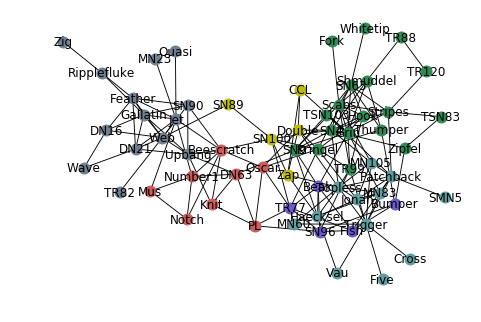

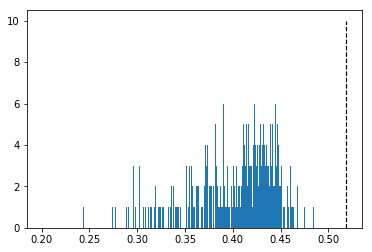

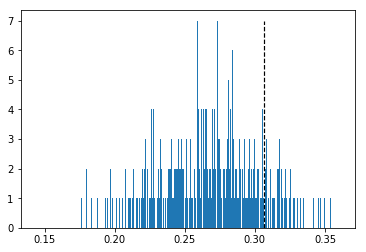

el pvalor de la modularidad es 0.0
el pvalor del slihouette es 0.14


In [13]:
##### infomap
G = nx.read_gml("dolphins.gml")
labels_infomap = community(G, "infomap")
Silmod(G, labels_infomap, fig_name = "G", metodo="infomap")
sss=Rsil(G, labels_infomap, fig_name = "G")
mmm=Rmod(G, labels_infomap, fig_name = "G")
listq=[]
lists=[]
nn=800 ###numero de randomizaciones
for rr in range(nn):
    R = nx.read_gml("dolphins.gml")
    nx.connected_double_edge_swap(R, nswap=30)
    labels_infomap = community(R, "infomap")
    ss=Rsil(R, labels_infomap, fig_name = "G")
    mm=Rmod(R, labels_infomap, fig_name = "G")
    listq.append(mm)
    lists.append(ss)
#print(listq)
#print(lists)



qqqx=[]
qqqy=[]
 
sssx=[]
sssy=[]
 



pq=plt.hist(listq, bins=nn, range=None, density=None)
mqq= list(pq[0])
PQ=list(pq)
for iq in range(int(max(mqq))+1):
    qqqx.append(mmm)
    qqqy.append(iq)
plt.plot(qqqx,qqqy,'k--',linewidth = 1.2)
plt.savefig("qhist_infomap.png")
plt.show()

ps=plt.hist(lists, bins=nn, range=None, density=None)
mss= list(ps[0])
PS=list(ps)
for si in range(int(max(mss))+1):
    sssx.append(sss)
    sssy.append(si)

plt.plot(sssx,sssy,'k--',linewidth = 1.2)
plt.savefig("shist_infomap.png")
plt.show()
pvalue(PQ,mmm, PS,sss)
    


[('DN16', 'Notch', 'Feather', 'TR82', 'Mus', 'Knit', 'Zig', 'Ripplefluke', 'Upbang', 'Web', 'Number1', 'Beescratch', 'MN23', 'Gallatin', 'SN90', 'Jet', 'DN21', 'Quasi', 'Oscar', 'PL', 'DN63', 'Wave'), ('TR99', 'Hook', 'Zipfel', 'Shmuddel', 'SN96', 'Fish', 'SN9', 'TR77', 'TR88', 'Kringel', 'SN63', 'Beak', 'Grin', 'Scabs', 'TSN103', 'TR120', 'Bumper', 'Fork', 'TSN83', 'Thumper', 'SN4', 'Stripes', 'Whitetip'), ('Haecksel', 'Patchback', 'Double', 'Jonah', 'Topless', 'CCL', 'MN105', 'Five', 'SMN5', 'MN60', 'Cross', 'Vau', 'Trigger', 'MN83', 'Zap'), ('SN89', 'SN100')]


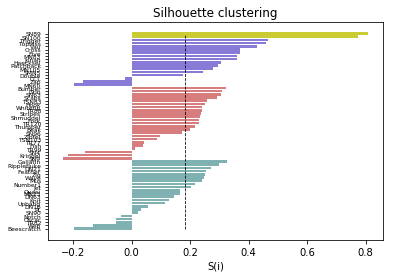

La modularidad es : 0.4954906847039266
El silhouette promedio es : 0.18392787933184088


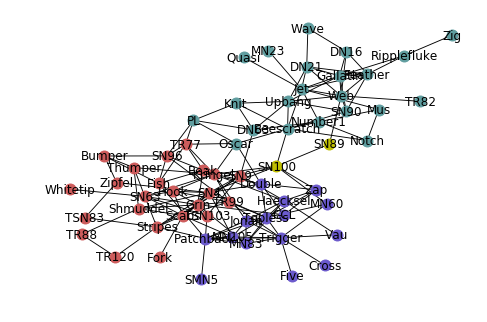

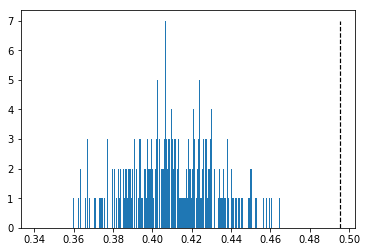

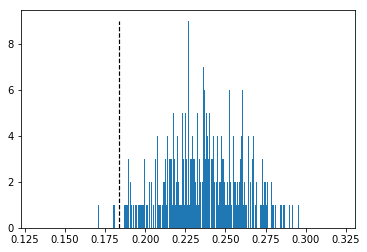

el pvalor de la modularidad es 0.0
el pvalor del slihouette es 0.01375


In [14]:
##### fast greedy
G = nx.read_gml("dolphins.gml")
labels_fast_greedy = community(G, "fast_greedy")
Silmod(G, labels_fast_greedy, fig_name = "G", metodo="fast_greedy")
sss=Rsil(G, labels_fast_greedy, fig_name = "G")
mmm=Rmod(G, labels_fast_greedy, fig_name = "G")
listq=[]
lists=[]
nn=800 ###numero de randomizaciones
for rr in range(nn):
    R = nx.read_gml("dolphins.gml")
    nx.connected_double_edge_swap(R, nswap=30)
    labels_fast_greedy = community(R, "fast_greedy")
    ss=Rsil(R, labels_fast_greedy, fig_name = "G")
    mm=Rmod(R, labels_fast_greedy, fig_name = "G")
    listq.append(mm)
    lists.append(ss)
#print(listq)
#print(lists)



qqqx=[]
qqqy=[]
 
sssx=[]
sssy=[]
 



pq=plt.hist(listq, bins=nn, range=None, density=None)
mqq= list(pq[0])
PQ=list(pq)
for iq in range(int(max(mqq))+1):
    qqqx.append(mmm)
    qqqy.append(iq)
plt.plot(qqqx,qqqy,'k--',linewidth = 1.2)
plt.savefig("qhist_fast_greedy.png")
plt.show()

ps=plt.hist(lists, bins=nn, range=None, density=None)
mss= list(ps[0])
PS=list(ps)
for si in range(int(max(mss))+1):
    sssx.append(sss)
    sssy.append(si)

plt.plot(sssx,sssy,'k--',linewidth = 1.2)
plt.savefig("shist_fast_greedy.png")
plt.show()
pvalue(PQ,mmm, PS,sss)


[('Beak', 'Oscar', 'PL', 'SN96', 'Bumper', 'Fish', 'TR77'), ('DN16', 'Notch', 'Feather', 'TR82', 'Mus', 'Knit', 'Zig', 'SN89', 'Ripplefluke', 'Upbang', 'Web', 'Number1', 'Beescratch', 'MN23', 'Gallatin', 'SN90', 'Jet', 'DN21', 'Quasi', 'DN63', 'Wave'), ('Kringel', 'SN63', 'SN4', 'TR99', 'Hook', 'Double', 'Grin', 'Stripes', 'TSN103', 'CCL', 'Scabs', 'Shmuddel', 'TR120', 'Fork', 'SN9', 'TR88', 'SN100', 'Thumper', 'Whitetip', 'Zap'), ('Haecksel', 'Patchback', 'Jonah', 'Topless', 'MN105', 'SMN5', 'Five', 'MN60', 'Cross', 'Vau', 'Trigger', 'MN83'), ('TSN83', 'Zipfel')]


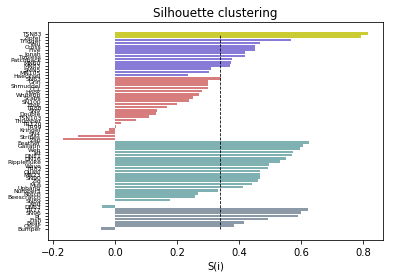

La modularidad es : 0.5193821446936422
El silhouette promedio es : 0.3381103690695859


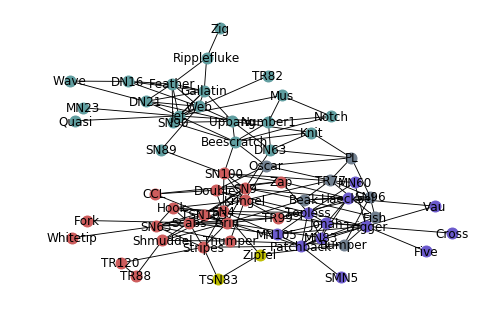

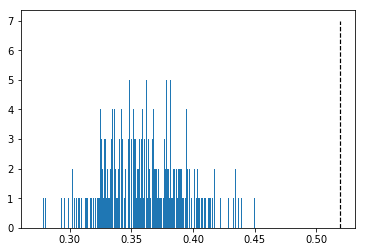

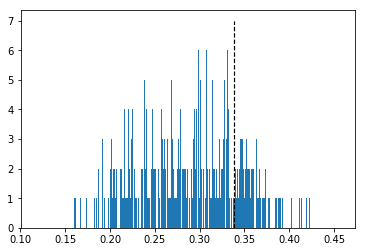

el pvalor de la modularidad es 0.0
el pvalor del slihouette es 0.17875


In [15]:
##### edge betwweenness
G = nx.read_gml("dolphins.gml")
labels_edge_betweenness = community(G, "edge_betweenness")
Silmod(G, labels_edge_betweenness, fig_name = "G", metodo="edge_betweenness")
sss=Rsil(G, labels_edge_betweenness, fig_name = "G")
mmm=Rmod(G, labels_edge_betweenness, fig_name = "G")
listq=[]
lists=[]
nn=800 ###numero de randomizaciones
for rr in range(nn):
    R = nx.read_gml("dolphins.gml")
    nx.connected_double_edge_swap(R, nswap=30)
    labels_edge_betweenness = community(R, "edge_betweenness")
    ss=Rsil(R, labels_edge_betweenness, fig_name = "G")
    mm=Rmod(R, labels_edge_betweenness, fig_name = "G")
    listq.append(mm)
    lists.append(ss)
#print(listq)
#print(lists)



qqqx=[]
qqqy=[]
 
sssx=[]
sssy=[]
 



pq=plt.hist(listq, bins=nn, range=None, density=None)
mqq= list(pq[0])
PQ=list(pq)
for iq in range(int(max(mqq))+1):
    qqqx.append(mmm)
    qqqy.append(iq)
plt.plot(qqqx,qqqy,'k--',linewidth = 1.2)
plt.savefig("qhist_edge_betweenness.png")
plt.show()

ps=plt.hist(lists, bins=nn, range=None, density=None)
mss= list(ps[0])
PS=list(ps)
for si in range(int(max(mss))+1):
    sssx.append(sss)
    sssy.append(si)

plt.plot(sssx,sssy,'k--',linewidth = 1.2)
plt.savefig("shist_edge_betweenness.png")
plt.show()
pvalue(PQ,mmm, PS,sss)


[('Beak', 'Zipfel', 'SN96', 'Bumper', 'Fish', 'TR77', 'TSN83'), ('Notch', 'Knit', 'Oscar', 'PL', 'DN63', 'Mus', 'Number1', 'Beescratch'), ('Kringel', 'SN63', 'SN4', 'TR99', 'Hook', 'Stripes', 'Grin', 'SN89', 'TSN103', 'TR120', 'Scabs', 'Shmuddel', 'Fork', 'SN9', 'TR88', 'SN100', 'Thumper', 'Whitetip'), ('DN16', 'Quasi', 'MN23', 'Zig', 'Gallatin', 'Ripplefluke', 'SN90', 'Feather', 'Jet', 'TR82', 'Upbang', 'Web', 'Wave', 'DN21'), ('Haecksel', 'Patchback', 'Double', 'Jonah', 'Topless', 'CCL', 'MN105', 'Five', 'SMN5', 'MN60', 'Cross', 'Vau', 'Trigger', 'MN83', 'Zap')]


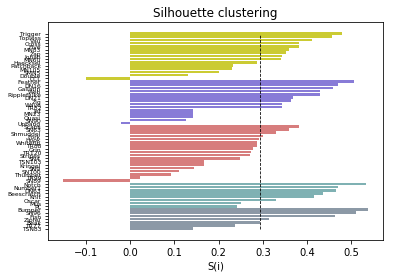

La modularidad es : 0.5185317036509626
El silhouette promedio es : 0.2940441808908354


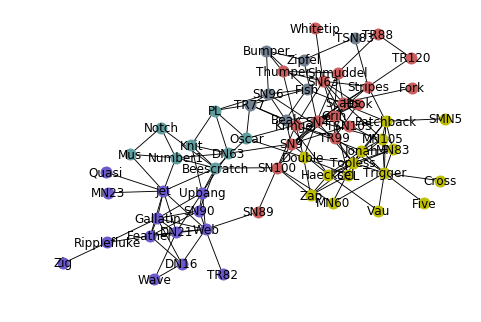

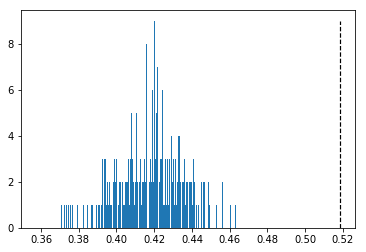

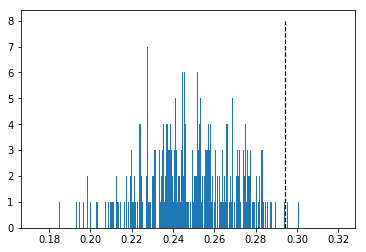

el pvalor de la modularidad es 0.0
el pvalor del slihouette es 0.01875


In [16]:
##### louvain
G = nx.read_gml("dolphins.gml")
labels_louvain = community(G, "louvain")
Silmod(G, labels_louvain, fig_name = "G", metodo="louvain")
sss=Rsil(G, labels_louvain, fig_name = "G")
mmm=Rmod(G, labels_louvain, fig_name = "G")
listq=[]
lists=[]
nn=800 ###numero de randomizaciones
for rr in range(nn):
    R = nx.read_gml("dolphins.gml")
    nx.connected_double_edge_swap(R, nswap=30)
    labels_louvain = community(R, "louvain")
    ss=Rsil(R, labels_louvain, fig_name = "G")
    mm=Rmod(R, labels_louvain, fig_name = "G")
    listq.append(mm)
    lists.append(ss)
#print(listq)
#print(lists)



qqqx=[]
qqqy=[]
 
sssx=[]
sssy=[]
 



pq=plt.hist(listq, bins=nn, range=None, density=None)
mqq= list(pq[0])
PQ=list(pq)
for iq in range(int(max(mqq))+1):
    qqqx.append(mmm)
    qqqy.append(iq)
plt.plot(qqqx,qqqy,'k--',linewidth = 1.2)
plt.savefig("qhist_louvain.png")
plt.show()

ps=plt.hist(lists, bins=nn, range=None, density=None)
mss= list(ps[0])
PS=list(ps)
for si in range(int(max(mss))+1):
    sssx.append(sss)
    sssy.append(si)

plt.plot(sssx,sssy,'k--',linewidth = 1.2)
plt.savefig("shist_louvain.png")
plt.show()
pvalue(PQ,mmm, PS,sss)


[('TR99', 'Hook', 'Zipfel', 'Shmuddel', 'SN96', 'Fish', 'SN9', 'TR77', 'TR88', 'Kringel', 'SN63', 'Beak', 'Grin', 'Scabs', 'TSN103', 'TR120', 'Bumper', 'Fork', 'TSN83', 'Thumper', 'SN4', 'Stripes', 'Whitetip'), ('DN16', 'Notch', 'Feather', 'TR82', 'Mus', 'Knit', 'Zig', 'Ripplefluke', 'Upbang', 'Web', 'Number1', 'Beescratch', 'MN23', 'Gallatin', 'SN90', 'Jet', 'DN21', 'Quasi', 'Oscar', 'PL', 'DN63', 'Wave'), ('Haecksel', 'Patchback', 'Double', 'Topless', 'Jonah', 'SMN5', 'CCL', 'Five', 'MN105', 'MN60', 'Cross', 'Vau', 'Trigger', 'MN83', 'Zap'), ('SN89', 'SN100')]


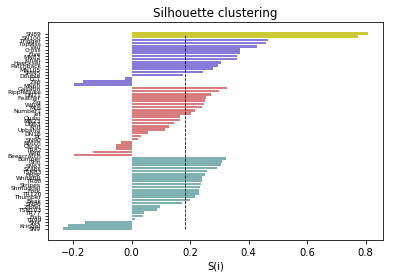

La modularidad es : 0.4954906847039279
El silhouette promedio es : 0.18392787933184088


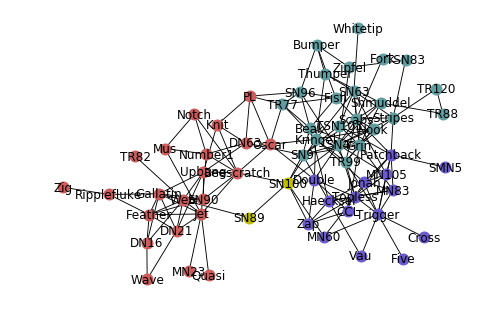

In [28]:
##### fast greedy
from networkx.algorithms import community
from networkx.algorithms.community import greedy_modularity_communities
G = nx.read_gml("dolphins.gml")
comus= nx.algorithms.community.greedy_modularity_communities(G, weight=None)
Silmodxxx(G, comus, fig_name = "G", metodo="prueb")






In [27]:
def Silmodxxx(G, comus, fig_name = "G",metodo= "metodo"):  ####Esta es una funcion, a la que uno le da un grafo G
                    #####una particion (labels) y Silmod devuelve la modularidad, el silhouette promedio
                ##### La red con las particionnes en colores y el grafico del silhouette con todos los valores
            ##### incluyendo el silhouette promedio con una linea punteada negra


    ###### Generar lista de edges de "dolphins.gml"
    edges = nx.write_edgelist(G,"Dolphins_edge_list.txt")
    filEdges = open("Dolphins_edge_list.txt", "r").readlines()	
    edgeList = []
    for a in range(len(filEdges)):
        edgeLine = filEdges[a].split()
        tupla = (edgeLine[0],edgeLine[1])
        edgeList.append(tupla)
    ###### OutputFile
    outputFile= open("./Silhouette_y_modularidad_%s.txt"%(metodo), "w")
    ##### Silhouette #################################
    ##################################################
    ###### Definir all_nodes y community_lists
    all_nodes = []
    comuList = []
    outputFile.write("Comunidades %s"%(metodo) + "\n")
    for x in range(len(comus)):
        lista = list(comus[x])
        all_nodes = all_nodes + lista
        comuList.append(tuple(lista))	
        str1 = ','.join(lista) 
        outputFile.write("Community_%s:"%str(x) + str1 + "\n")
        # Defino node_community_lists
        globals()['node_list_community%s' % x] = lista

    print(comuList)
    count=0
    Dict={}
    listSilhs = []
    for i in range(len(comus)):
        listSilhs.append([])
    ### Separar comuList en listas de comunidades
    for q in range(len(comuList)):
        comm = (list(comuList[q]))	

        # Abro y defino comunidad No X
        globals()['community_%s' % q] = comm

        # Abro la comunidad No X y determino la shortest_path_length de cada uno de sus nodos con respecto a todo el grafo
        for m in range(len(comm)):

            # Defino Nodo como "source"
            source = comm[m]

            # Diccionario de shorttest path length desde el nodo "source" hasta el resto de los nodos del grafo
            spl = nx.multi_source_dijkstra_path_length(G, [source])

            # Variables ##########################################
            # Defino las variables suma y total para calcular a(i)
            suma = 0
            #total = len(globals()['community_%s' % q])
            total = len(comuList[q])

            # Defino las variables suma_x y total_x para calcular b(i) del resto de las comunidades
            for w  in range(len(comuList)):	
                globals()['suma_%s' % w] = 0
                globals()['total_%s' % w] = len(comuList[w])
            ######################################################	

            # Abro el diccionario spl, y calculo a(i), b(i)
            for x,y in spl.items():

                # Si el nodo esta en la comunidad: sumar la dist para calcular a(i) promediando
                if x in (globals()['community_%s' % q]):	
                    suma = suma + y

                # Si el nodo NO esta en la comunidad q del inicio del loop: 
                if x not in (globals()['community_%s' % q]):	

                    # Volver a abrir la lista de comunidades
                    for w  in range(len(comuList)):	

                        # Y sumar la dist correspondiente a cada comunidad para b(i)
                        if x in globals()['node_list_community%s' % w]:
                            globals()['suma_%s' % w] = globals()['suma_%s' % w] + y


            # Determinacion de a(i)
            ai = suma/total

            # Determinacion de b(i)
            bi_list = []
            for oo in range(len(comuList)):
                globals()['promedio_%s' % oo] = (globals()['suma_%s' % oo])/(globals()['total_%s' % oo])
                if globals()['promedio_%s' % oo] != 0.0:
                    bi_list.append(globals()['promedio_%s' % oo])

            bi = min(bi_list)
            MAX =  max(ai, bi)
            Silh = (bi - ai)/MAX

            # Guardar Silh en una lista para cada comunidad:
            listSilhs[q].append(tuple([source,Silh]))
        listSilhs[q].sort(key=itemgetter(1))

    ##################################################
    ##################################################
    
            #### Calculo del silhouette promedio
    pp=0
    llistasilh=[]
    for ii in range(len(listSilhs)):
        for jj in range(len(listSilhs[ii])):
            llistasilh.append(((listSilhs[ii])[jj])[1])


    for si in range(len(llistasilh)): ####no se si esta parte esta bien, para mi que hay que quitarle un tab pero da un solo silhuette para cualquier caso
        pp=pp+llistasilh[si]
    s = pp/(len(llistasilh))
    #print("El silhouette promedio es : %s"%str(s))
    outputFile.write("El silhouette promedio es :%s"%str(s) + '\n')
    
    ##################################################################
    ##### Plotear Silhouette #########################################
    objects = []
    performance = []

    # Armar lista de colorIdenx
    colorIndex = []
    for li in range(len(listSilhs)):
        for co in range(len(listSilhs[li])):
            tup=(listSilhs[li])[co]
            objects.append(tup[0])
            performance.append(tup[1])
        colorIndex.append(	len(listSilhs[li]))
    colorIndex.reverse()

    # Definir lista de nombres de colores
    colorName=[]
    for i in range(len(colorIndex)):
        if i==0:
            colorName.append('y')
        elif i==1:
            colorName.append('slateblue')
        elif i==2:
            colorName.append('indianred')  
        elif i==3:
            colorName.append('cadetblue')
        elif i==4:
            colorName.append('slategrey')
        elif i==5:
            colorName.append('seagreen')
        elif i==6:
            colorName.append('darkkhaki')
        elif i==7:
            colorName.append('olive')
        elif i==8:
            colorName.append('saddlebrown')
        elif i==9:
            colorName.append('blue')
        elif i==10:
            colorName.append('goldenrod')
        elif i==11:
            colorName.append('olivedrab')
        elif i==12:
            colorName.append('streetblue')
        elif i==13:
            colorName.append('y')
        elif i==14:
            colorName.append('red')
        elif i==15:
            colorName.append('firebrick')


    #colorName = ['green', 'blue', 'red', 'cyan', 'yellow','darkgray','bisque', 'black', 'pink','brown', 'cadetblue']

    # Armar lista de colores con la cantidad correspondiente a cada comunidad
    COLOR = []
    for col in range(len(colorIndex)):
        for colo in range(colorIndex[col]):
            COLOR.append(colorName[col])
    COLOR.reverse()
        # Ploteo
    SSx=[]
    SSy=[]
    for qp in range(len(performance)):
        SSx.append(s)
        SSy.append(qp)


    
    y_pos = np.arange(len(objects))	
    plt.barh(y_pos, performance, align='center', alpha=0.8,color=COLOR )
    plt.plot(SSx,SSy,'k--',linewidth = 0.8)
    plt.yticks(y_pos, objects, fontsize=6)
    plt.xlabel('S(i)')
    plt.title('Silhouette clustering')
    plt.savefig('%s_silhouette.png' %(metodo))
    plt.show()
    ##################################################################
    ##################################################################

    ###### Calculo de modularidad
    q = nx.algorithms.community.modularity(G,comus)
    print("La modularidad es : %s"%str(q))
    print("El silhouette promedio es : %s"%str(s))
    outputFile.write("La modularidad es : %s"%str(q) + '\n')

    ###################################################################
    ###### Plotear grafo con comunidades ##############################
    G3 = nx.Graph()
    for n in all_nodes:
        G3.add_node(n)
    for from_loc, to_loc in edgeList:
        G3.add_edge(from_loc, to_loc)

    pos = nx.kamada_kawai_layout(G3) 
    nx.draw(G3, pos, edge_color='k',  with_labels=True,font_weight='light', node_size= 80, width= 0.9)

    # Graficar la red con un color para cada comunidad, igual al empleado en Silhouette
    colorName.reverse()
    for col in range(len(colorIndex)):
        nx.draw_networkx_nodes(G3, pos, nodelist=globals()['node_list_community%d'% col], node_color=colorName[col], node_size=120)
    plt.savefig('labels_%s.png' %(metodo))
    plt.show()   
    
    
    outputFile.close()